In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sympy
import ipywidgets

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

In [2]:
sympy.init_printing()

In [3]:
u_max = sympy.symbols('u_max')
u_star = sympy.symbols('u_star')
rho_max = sympy.symbols('rho_max')
rho_star = sympy.symbols('rho_star')
A, B = sympy.symbols('A B')

In [4]:
type(u_max)

sympy.core.symbol.Symbol

In [5]:
u_max

In [6]:
u_max + u_star

In [7]:
eq1 = sympy.Eq(0, rho_max * u_max * (1 - A*rho_max - B*rho_max**2))
eq2 = sympy.Eq(0, u_max*( 1 - 2*A*rho_star - 3*B*rho_star**2))
eq3 = sympy.Eq(u_star, u_max*(1 - A*rho_star - B*rho_star**2))
eq1

In [8]:
eq2

In [9]:
eq3

In [10]:
eq2 - 3*eq3

In [11]:
eq4 = sympy.Eq(eq2.lhs - 3*eq3.lhs, eq2.rhs - 3*eq3.rhs)
eq4

In [12]:
eq4.simplify()

In [13]:
rho_star_sol = sympy.solve(eq4, rho_star)[0]
rho_star_sol

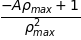

In [14]:
B_sol = sympy.solve(eq1, B)[0]
B_sol

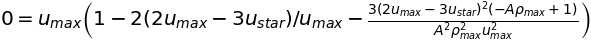

In [15]:
eq5 = eq2.subs([(rho_star, rho_star_sol), (B, B_sol)])
eq5

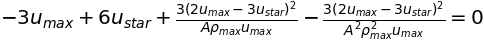

In [16]:
eq5.simplify()

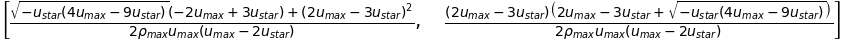

In [17]:
A_sol = sympy.solve(eq5, A)
A_sol

In [18]:
A_val_0 = A_sol[0].evalf(subs={rho_max: 10.0, u_max: 1.0, u_star: 0.7})
A_val_0

In [19]:
A_val_1 = A_sol[1].evalf(subs={rho_max: 10.0, u_max: 1.0, u_star: 0.7})
A_val_1

In [20]:
A_val = max(A_val_0, A_val_1)
A_val

In [21]:
B_val = B_sol.evalf(subs={rho_max: 10.0, A: A_val})
B_val

In [22]:
def cubic_flux(rho, u_max, A, B):
    floox = rho * u_max * (1.0 - A*rho - B*rho**2)
    return floox

In [23]:
rho_max = 10.0
u_max = 1.0

L = 4.0
nt = 30
nx = 81
dx = L / (nx - 1)
x = np.linspace(0.0, L, num=nx)

In [24]:
rho0 = np.zeros_like(x)
mask = x < 2.0
rho0[mask] = rho_max * x[mask] / 2

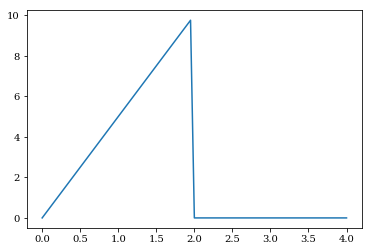

In [25]:
plt.plot(x, rho0)

In [26]:
def ftbs(rho0, nt, dt, dx, bc_value, *args):
    rho_hist = [ rho0.copy() ]
    rho = rho0.copy()
    
    for n in range(nt):
        F = cubic_flux(rho, *args)
        
        rho[1:] = rho[1:] - dt / dx * (F[1:] - F[:-1])
        
        rho[0] = bc_value
        rho_hist.append(rho.copy())
    
    return rho_hist

In [27]:
# Set time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# Compute the traffic density at all time steps.
rho_hist = ftbs(rho0, nt, dt, dx, rho0[0], u_max, A_val, B_val)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


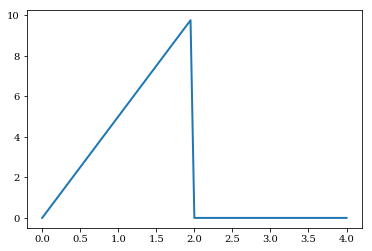

In [28]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(6.0, 4.0))
line = plt.plot(x, rho0, color='C0', linestyle='-', linewidth=2)[0]

def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [29]:
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

In [39]:
def cleaner_lf(rho0, nt, dt, dx, bc_val, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    nx = len(rho0)
    nx = rho.size
    for n in range(nt):
        rho_n = rho.copy()
        F = cubic_flux(rho_n, *args)
        for i in range(1, nx - 1):
            rho[i] = (0.5 * (rho_n[i+1] + rho_n[i - 1]) -
                     dt * (F[i+1] - F[i - 1]) / (2*dx))
            #rho[1:-1] = 0.5 * (rho[2:] + rho[:-2]) - dt*(F[2:] - F[:-2]) / (2*dx)
        rho_hist.append(rho.copy())
    return rho_hist

In [40]:
# Set time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# Compute the traffic density at all time steps.
rho_hist2 = cleaner_lf(rho0, nt, dt, dx, rho0[0], u_max, A_val, B_val)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [38]:
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist2,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())